In [1]:
import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

In this notebook we implement three versions of gradient descent w/ linear regression: batch, regularized and stochastic. First a theoretic discussion about the square loss function which we will be using: it has the Bayes Optimal Predictor of the form $g(x) = \boldsymbol{E}[Y|X=x]$, which achieves the minimal risk among all possible hypothesis functions. 

Specifically, for data, target pair $(x, y)$ drawn i.i.d. from $P_{X,Y}(x,y)$, $R(f)$ the expected loss of a decision function $f$ where $R(f) = \boldsymbol{E} \left( l(f(x), y) \right)$ , we show $g$ has the property that $R(g) = \inf_f R(f)$. 

Given the hypothesis function $g: X \rightarrow Y$ and square loss function $l(g, (x,y)) = \frac{1}{2}\left(g(x) - y\right)^2$:

\begin{align*}
\boldsymbol{E}\left(\frac{1}{2}(Y - g(X))^2 \right) & = \frac{1}{2} \boldsymbol{E}\left( \left( Y - \boldsymbol{E} \left( Y |X \right) + \boldsymbol{E} \left( Y |X \right) - g(X)\right)^2 \right) \\
 & = \frac{1}{2} \boldsymbol{E}\left( \boldsymbol{E} \left( Y - \boldsymbol{E} \left( Y |X \right) + \boldsymbol{E} \left( Y |X \right) - g(X)\right)^2 | X \right) \text{ By Law of Total Expectation}\\
 & = \frac{1}{2} \boldsymbol{E} \left(  \text{Var}(Y|X) \right) +  \boldsymbol{E} \left( \boldsymbol{E}(Y|X) - g(X) \right) ^2
\end{align*}

Since $g(x) = \boldsymbol{E}(Y|X = x)$, set the last line above to be conditioned by the deterministic variable $X = x$. Only the expectation of variance $\boldsymbol{E}\left(\text{Var}(Y|X=x)\right) $ remains, which is the irreducible error w.r.t. sample $x$. No other hypothesis function $f \in F$ can achieve a lower expected loss, as was claimed.

In [264]:
#dummy = np.array([[1, 1, 1],[2, 2, 2],[3, 3, 3]], dtype=float)
file = 'hw1-data.csv'
df = pd.read_csv(file, delimiter=',')
X = df.values[:,:-1]
y = df.values[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 100, random_state=10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(100, 48) (100,) (100, 48) (100,)


In [265]:
def feature_normalization(train, test):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size (num_instances, num_features)
        test  - test set, a 2D numpy array of size (num_instances, num_features)
    Returns:
        train_normalized - training set after normalization
        test_normalized  - test set after normalization
    """
    for col in range(train.shape[1]):
        minimum = np.nanmin(train[:,col])
        train[:, col] -= minimum
        test[:, col] -= minimum
        
        max_ = np.nanmax(train[:,col])
        train[:,col] /= max_
        test[:,col] /= max_
        
    return train, test

In [266]:
X_train, X_test = feature_normalization(X_train, X_test)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1)))) # Add bias term

In [284]:
theta = np.full(49, fill_value= 1, dtype=np.float)

def compute_square_loss(theta, X, y):
    """
    Given a set of X, y, theta, compute the square loss for predicting y with X*theta
    Args:
        feature - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D array of size (num_features)
    Returns:
        loss - the square loss, scalar
    """
    residual = np.matmul(X, theta )-y
    return (np.dot(residual,residual))/(2*X.shape[0])

print(compute_square_loss(theta, X_train, y_train))

441.434261024


In [268]:
def compute_square_loss_gradient(theta, X, y):
    """
    Compute gradient of the square loss (as defined in compute_square_loss), at the point theta.
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    residual = np.dot(X, theta) - y
    return np.dot(X.T, residual )/(X.shape[0])

compute_square_loss_gradient(theta, X_train, y_train)

array([ 26.07013205,  25.58326502,  25.05054258,  24.74081471,
        24.24546864,  23.79891226,  22.90863314,  22.90863314,
        21.90026135,  20.0569049 ,  18.36416632,  17.3017451 ,
        14.5002761 ,  12.45800123,   8.21040281,   7.34556074,
         5.24340575,   0.90770525,  23.14742097,  23.14742097,
        23.14742097,  21.48832491,  21.48832491,  21.48832491,
        19.8972414 ,  19.8972414 ,  19.8972414 ,  19.15895467,
        19.15895467,  19.15895467,  18.74898619,  18.74898619,
        18.74898619,  11.85229611,  11.85229611,  11.85229611,
        14.39885467,  14.39885467,  14.39885467,  15.83930209,
        15.83930209,  15.83930209,  16.49353617,  16.49353617,
        16.49353617,  16.85255853,  16.85255853,  16.85255853,  26.23768143])

In [269]:
def unit_vec(num_features):
    z = np.zeros(num_features-1)
    for i in range(num_features):
        yield np.insert(z, i, 1)

#theta = np.ones(48)
#theta = np.append(theta, 100)
def grad_checker(theta, X, y,  epsilon=0.01, tolerance=1e-4): 
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions: 
    (e_1 = (1,0,0,...,0), e_2 = (0,1,0,...,0), ..., e_d = (0,...,0,1) 

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by: 
    ( J(theta + epsilon * e_i) - J(theta - epsilon * e_i) ) / (2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error
    
    Return:
        A boolean value indicate whether the gradient is correct or not
    """
    true_gradient = compute_square_loss_gradient(theta, X, y) 
    num_features = theta.shape[0]
    
    approx_grad = []
    for u in unit_vec(num_features):
        approx_grad.append((compute_square_loss(theta+epsilon*u, X, y) - 
                             compute_square_loss(theta-epsilon*u, X, y))/(2*epsilon))
        
    difference = np.linalg.norm(np.array(approx_grad)-true_gradient)
    correct =  difference <= tolerance 
    if not correct:
        print(correct, difference)
        raise Exception('incorrect gradient')
        
    return correct

grad_checker(theta, X_train, y_train)

True

In [9]:
def unit_vec(num_features):
    z = np.zeros(num_features-1)
    for i in range(num_features):
        yield np.insert(z, i, 1)

def f(*args):
    args = list(args)
    theta = args[2]
    num_features = theta.shape[0]
    
    obj_func = args[1]
    X = args[3]
    y = args[4]
    epsilon = args[5]
    L = args[6]
    approx_grad = []
    for u in unit_vec(num_features):
        try:
            approx_grad.append((obj_func(theta+epsilon*u, X, y) 
                                - obj_func(theta-epsilon*u, X, y))/(2*epsilon))
        except:
            approx_grad.append((obj_func(theta+epsilon*u, X, y, L) 
                                - obj_func(theta-epsilon*u, X, y, L))/(2*epsilon))
    try:
        true_g = args[0](theta, X, y)
    except:
        true_g = args[0](theta, X, y, L)
    
    tolerance = args[6]
    
    difference = np.linalg.norm(np.array(approx_grad)-true_g)
    correct =  difference <= tolerance
    
    if not correct:
        print(correct, difference)
        raise Exception('incorrect gradient')
    return correct

def gen_grad_checker(f1, f2):
    epsilon = 0.01
    tolerance = 1e-4
    L = 0.1
    theta = np.ones(X_train.shape[1])
    return f(f1, f2, theta, X_train, y_train,  epsilon, tolerance, L)

gen_grad_checker(compute_square_loss_gradient, compute_square_loss)

True

Linear Regression 

$J(\theta)  = \frac{1}{2m} \sum ^m _{i=1} (h_\theta(x_i) - y_i)^2$

In [377]:
def backtrack_line_search(fx, gradient, X, y, theta, alpha):
    tau = c = 0.5
    p = -gradient
    m = np.dot(p, gradient)
    t = c*m
    
    step = (compute_square_loss((theta.T + alpha*p).flatten(), X, y))

    #  Armijo-Goldstein cond: f(x) - f(x+ alpha_j * p) >= alpha_j * t
    while step- fx > alpha*t :
        alpha *= tau
        step = (compute_square_loss((theta.T + alpha*p).flatten(), X, y))
        
    return alpha

def batch_grad_descent(X, y, alpha=0.5, num_iter=1000, check_gradient=False, l_search = True):
    
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #initialize loss_hist
    theta = np.ones(num_features) #initialize theta
    a_hist = [alpha]
  
    
    for i in range(num_iter):
        
        loss = compute_square_loss(theta, X, y)
        gradient = compute_square_loss_gradient(theta, X, y)
        
        #check terminal conditions: obj. func stop improving or gradient too small
        if i != 0 and (loss >= loss_hist[i-1] or np.dot(gradient.T, gradient) <= 1e-3): 
            print(a_hist)
            return(loss_hist[0:i], theta_hist[0:i,:])
        
        loss_hist[i] = loss # record loss
        
        if check_gradient:
            grad_checker(theta, X, y)
            #gen_grad_checker(compute_square_loss_gradient, compute_square_loss)
        
        start = time.time()
        if l_search: #line search call
            alpha= backtrack_line_search(loss, gradient, X, y, theta, alpha)
            a_hist.append(round(alpha,4))
        
        theta -= alpha*gradient
        theta_hist[i,:] = theta
    
    #print(a_hist)
    return loss_hist, theta_hist

loss_hist, theta_hist = batch_grad_descent(X_train, y_train, alpha = 0.4)

In [260]:
loss_hist

array([ 441.43426102,  105.02617008,   27.40198854,    9.46237482,
          5.28739045,    4.28807172,    4.02341519,    3.99671389,
          3.99671389])

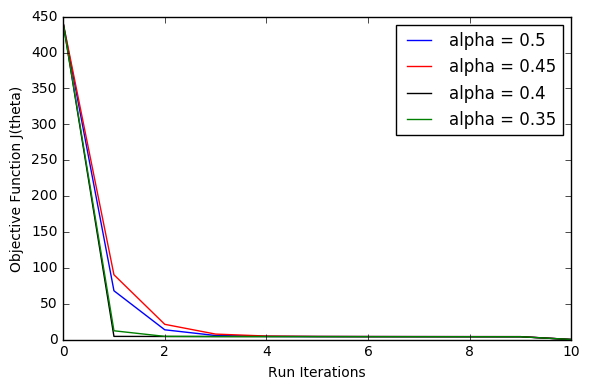

In [375]:
def alpha_graph(X, y, regularized = False):
    
    plt.rc('axes', prop_cycle=(cycler('color', ['b', 'r', 'k', 'g']) +
                           cycler('linestyle', ['-', '-', '-', '-'])))
    l = []
    alphas = [0.5, 0.45, 0.4,0.35]
    for size in alphas:
        if regularized:
            output = regularized_grad_descent(X, y, alpha = size, lambda_reg = 10e-2, l_search = True)
        else:
            output = batch_grad_descent(
                X, y, alpha = size, l_search = True, num_iter = 10)
        #loss_hist, theta_hist = p
        l.append(output[0])
    #c = ['b', 'k', 'r',  'g'] 
    s = [221+i for i in range(len(l))]
    #fig = plt.figure()

    for i in range(len(l)):
        #ax = fig.add_subplot(s[i])
        #ax.set_ylim([0, 150])
        #ax.set_xlim([0, 80])#len(l[i])])
        #ax.plot(l[i])
        plt.plot(range(len(l[i])), l[i], label='alpha = %s' %( round(alphas[i],2) ))
    axes = plt.gca()
    axes.set_xlim([0,10])
    #axes.set_ylim([0,80])
    #for i in range(4):
    #    print([ '%.2f' % elem for elem in l[i] ])
    plt.xlabel('Run Iterations')
    plt.ylabel('Objective Function J(theta)')
    plt.legend()
    plt.tight_layout()
    plt.show()

alpha_graph(X_train, y_train, regularized = False)

Ridge Regression (Linear Regression with $L_2$ regularization) 

$J(\theta)  = \frac{1}{2m} \sum ^m _{i=1} (h_\theta(x_i) - y_i)^2 + \lambda \theta^T \theta$

In [327]:
def r_sq_loss(theta, X, y, lambda_reg):
    return compute_square_loss(theta, X,y) + lambda_reg*np.dot(theta.T, theta)

def compute_regularized_square_loss_gradient(theta, X, y, lambda_reg):
    residual = np.dot(X, theta) - y 
    
    if len(X.shape)==1:
        return X*residual + theta*lambda_reg*2
        
    return np.matmul(X.T, residual )/(X.shape[0]) + 2*theta*lambda_reg

#compute_regularized_square_loss_gradient(theta, X_train, y_train, lambda_reg = 0.2)
# check regularized gradient computation w/ finite difference
#gen_grad_checker(compute_regularized_square_loss_gradient, r_sq_loss)

In [358]:
import time    

#time measuring decorator that is called as a wrapper by @timeit above func names
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        #print('%r (%r, %r) %2.2f sec' %(method.__name__, args, kw, te-ts))
        print('%r %2.5f sec' %(method.__name__, te-ts))
        return result
    return timed

In [357]:

def regularized_grad_descent(X, y,  lambda_reg, alpha=5, num_iter=2000, 
                             check_gradient=False, l_search = True):

    (num_instances, num_features) = X.shape
    theta = np.append(np.ones(num_features-1), 1) #Initialize theta w/ bias
    theta_hist = np.zeros((num_iter, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter) #initialize loss_hist
    a_hist = [alpha]
    
    for i in range(num_iter):
        
        loss = r_sq_loss(theta, X, y, lambda_reg)
        loss_hist[i] = loss
        
        gradient = compute_regularized_square_loss_gradient(theta, X, y, lambda_reg)
        if i != 0 and loss >= loss_hist[i-1]:#(np.dot(gradient.T, gradient) <= 1e-6):
            #print(a_hist)
            return(loss_hist[0:i-1], theta_hist[0:i-1, :])
        
        if l_search:
            alpha= backtrack_line_search(loss, gradient, X, y, theta, alpha)
            a_hist.append(round(alpha,4))
        
        theta -= alpha*gradient
        theta_hist[i,:] = theta
        
    #print(a_hist)
    return loss_hist, theta_hist

loss_hist, theta_hist = regularized_grad_descent(
    X_train, y_train, l_search = True, alpha = 0.1, lambda_reg = 0.5, num_iter = 1000)
#loss_hist
#len(loss_hist), loss_hist[-1]

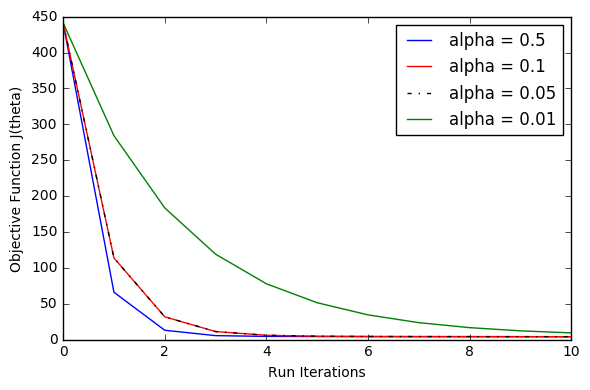

In [343]:
alpha_graph(X_train, y_train, regularized=True)

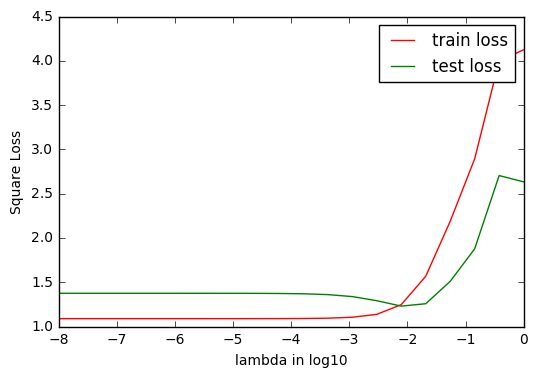

In [320]:
def lambda_graph(X, y):
    #lambda_ = [10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 1, 10, 100]#[0.1, 0.5, 0.7, 1, 2, 3, 4, 5, 10, 100]
    #lambda_ = range(10)
    #lambda_plot = [np.log10(x) for x in lambda_]
    lambda_plot = np.logspace(-8, 0, num=20)
    
    data = [(X_train, y_train, 'train loss'),(X_test, y_test, 'test loss')]
    #for pair in data:
    l1 = []
    l2 = []
    for lamb in lambda_plot:
        loss_hist, theta_hist = regularized_grad_descent(
            data[0][0], data[0][1], 
            alpha = 1, l_search = True, lambda_reg = lamb, num_iter=2000)
            #print(theta_hist.shape)
            #loss = 
        l1.append(compute_square_loss(theta_hist[-1], data[0][0], data[0][1]))
        l2.append(compute_square_loss(theta_hist[-1], data[1][0], data[1][1]))
        
    plt.plot(np.log10(lambda_plot), l1 , label='%s' %(data[0][2])) 
    plt.plot(np.log10(lambda_plot), l2 , label='%s' %(data[1][2])) 
    
    #plt.plot(lambda_plot, l)
    plt.xlabel('lambda in log10')
    plt.legend()
    plt.ylabel('Square Loss')
    plt.show()
    
lambda_graph(X_train, y_train)

In [200]:
np.logspace(-8, 1, num=20)

array([  1.00000000e-08,   2.97635144e-08,   8.85866790e-08,
         2.63665090e-07,   7.84759970e-07,   2.33572147e-06,
         6.95192796e-06,   2.06913808e-05,   6.15848211e-05,
         1.83298071e-04,   5.45559478e-04,   1.62377674e-03,
         4.83293024e-03,   1.43844989e-02,   4.28133240e-02,
         1.27427499e-01,   3.79269019e-01,   1.12883789e+00,
         3.35981829e+00,   1.00000000e+01])

In [409]:
#@timeit
def stochastic_grad_descent(
    X, y, alpha, switch, lambda_reg=10e-2, num_iter=1000, epi = 10e-3):
    (num_instances, num_features) = X.shape
    theta = np.ones(num_features) #Initialize theta
    theta_hist = np.zeros((num_iter, num_features))  #Initialize theta_hist
    loss_hist = np.zeros((num_iter, num_instances)) #initialize loss_hist
    a_hist = [alpha]
    
    s = [i for i in range(num_instances)]
    S =  np.random.permutation(s)
    for i in range(num_iter):
        
        for j in S:
            gradient = compute_regularized_square_loss_gradient(theta, X[j,:], y[j], lambda_reg)
            #if np.linalg.norm(gradient) <= epi:
            #    return(loss_hist[0:i], theta_hist[0:i, :])
            
            #if i != 0 or j != 0:
            #    if not switch:
            #        step = alpha/ (i*num_instances + j)
            #    else: 
            #        step = alpha/ np.sqrt(i*num_instances + j)
#             a_hist.append(step)
            
            theta -= alpha * gradient
            loss = r_sq_loss(theta, X, y, lambda_reg)
            loss_hist[i,j] = loss
            theta_hist[i] = theta
    #print(a_hist)
    return loss_hist, theta_hist

loss_hist, theta_hist = stochastic_grad_descent(X_train, y_train, switch=True, alpha = 0.01, lambda_reg = 10e-2, num_iter=1000)

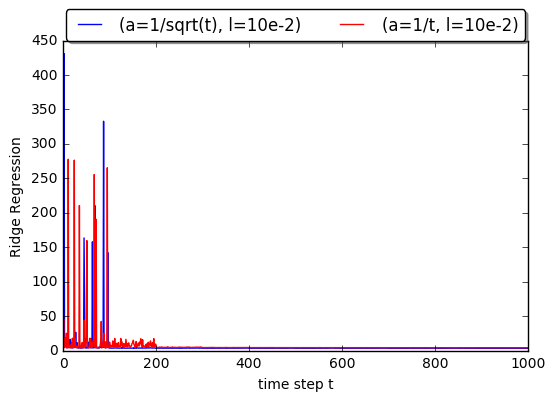

In [408]:
#studying convergence of objective function for updated step sizes
from cycler import cycler
alpha = [True, False]
plt.rc('axes', prop_cycle=(cycler('color', ['b', 'r', 'k', 'g']) +
                           cycler('linestyle', ['-', '-', '-.', '-'])))
for s in alpha:
    ls, ts = stochastic_grad_descent(X_train, y_train, alpha = 0.1, switch=s, num_iter = 10)
    ls = ls.flatten()
    if s:
        plt.plot(range(len(ls)), (ls), label='(a=1/sqrt(t), l=10e-2)')
    else:
        plt.plot(range(len(ls)), (ls), label='(a=1/t, l=10e-2)')# %(10e-2))
    
plt.legend(loc='center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.xlabel('time step t')
#plt.ylim([0,10])
#plt.xlim([0, 200])
plt.ylabel('Ridge Regression')
plt.show()

[ 4.50353153  3.27619294  3.74165575  8.06508111]
[ 3.36864502  3.35616358  3.41324729  3.54888714]
[ 3.3208584   3.16500222  3.2546754   3.60446248]


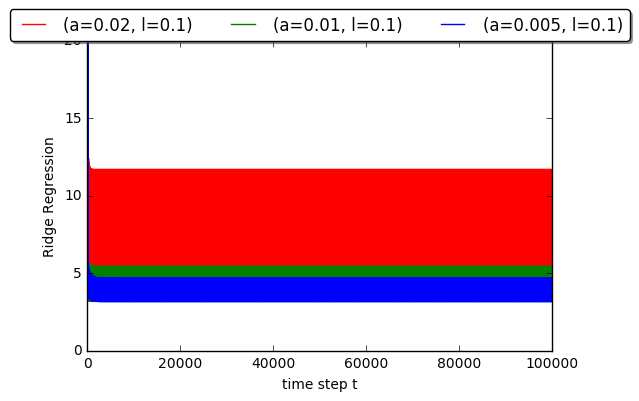

In [411]:
#studying convergence of objective function for fixed step sizes
alpha = [ 0.02, 0.01, 0.005]
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y']) +
                           cycler('linestyle', ['-', '-', '-', '-'])))
for a in alpha:
    ls, ts = stochastic_grad_descent(X_train, y_train, switch = False, alpha = a, num_iter = 1000)
    ls = ls.flatten()
    plt.plot(range(len(ls)), (ls), label='(a=%s, l=%s)' %(a, 10e-2))
    print(ls[-5:-1])
plt.legend(loc='center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.xlabel('time step t')
plt.ylim([0,20])
#plt.xlim([0, 100])
plt.ylabel('Ridge Regression')
plt.show()

In [25]:
def mini_batch_GD(X, y, alpha, b_size, lambda_reg=10e-2, num_iter=100, epi = 10e-3):
    (num_instances, num_features) = X.shape
    theta = np.ones(num_features) #Initialize theta
    theta_hist = np.zeros((num_iter, num_features))  #Initialize theta_hist
    loss_hist = []#np.zeros((num_iter, num_instances)) #initialize loss_hist
    a_hist = [alpha]
    
    s = [i for i in range(num_instances)]

    j=0
    for i in range(num_iter):
        S =  np.random.permutation(s)
        minibatches = np.split(S, num_instances/b_size)
        #print(len(minibatches), minibatches[-1])
    
        for mb in minibatches:
    
            gradient = compute_regularized_square_loss_gradient(theta, X[list(mb),:], y[list(mb)], lambda_reg)
            if np.linalg.norm(gradient) <= epi:
                return(loss_hist[0:i], theta_hist[0:i, :])
            loss = r_sq_loss(theta, X, y, lambda_reg)
            
            if j>0:
                step = alpha/j
                theta -= step * gradient
            else:
                theta -= alpha* gradient
            
            loss_hist.append(loss)
            theta_hist[i] = theta
            
            j+=1
    #print(a_hist)
    return loss_hist, theta_hist

#loss_hist, theta_hist = mini_batch_GD(X_train, y_train, b_size = 1, alpha = 0.1, lambda_reg = 10e-2)
#plt.plot(range(len(loss_hist)), loss_hist)
#plt.show()

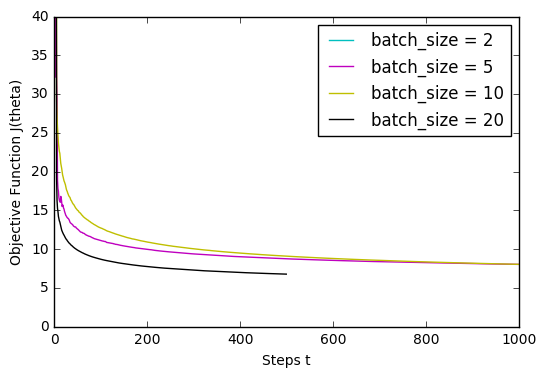

In [26]:
from cycler import cycler
from collections import OrderedDict

#plots convergence of regularized ridge reg. w/ mini-batch SGD, plots vary between batch sizes.

def alpha_graph2(X, y, regularized = False):
    l = []
    b_size = [2, 5, 10, 20]

    c = ['c', 'm', 'y', 'k', 'b']
    i=0
    for b in b_size:
        output = mini_batch_GD(X, y, b_size = b, alpha = 0.15)
        #l.append(output[0])
        loss = output[0]
        #print(b, loss.shape)
        plt.plot(range(len(loss)), loss, color = c[i], ls = '-', label='batch_size = %s' %( round(b,2) ))
        i+=1
 
    plt.xlabel('Steps t')
    plt.ylabel('Objective Function J(theta)')

    plt.xlim([0, 1000])
    plt.ylim([0, 40])
    plt.legend()
    plt.show()
alpha_graph2(X_train, y_train)

In [27]:

b_size = [2, 5, 10, 20]
for b in b_size:
    output = mini_batch_GD(X, y, b_size = b, alpha = 0.1)

In [51]:
np.logspace(-5, 3, num=20)

array([  1.00000000e-05,   2.63665090e-05,   6.95192796e-05,
         1.83298071e-04,   4.83293024e-04,   1.27427499e-03,
         3.35981829e-03,   8.85866790e-03,   2.33572147e-02,
         6.15848211e-02,   1.62377674e-01,   4.28133240e-01,
         1.12883789e+00,   2.97635144e+00,   7.84759970e+00,
         2.06913808e+01,   5.45559478e+01,   1.43844989e+02,
         3.79269019e+02,   1.00000000e+03])

In [28]:
#this cell is no longer executable, dont run it
#it plots the effects of shuffling the data samples once at the beginning of SGD vs at every new epoch of SGD, 
#as can be seen by the theta differences, they convege at later epochs at a variety of alpha and lambda parameter values
#leading me to believe convergence to optimal theta occurs at the same rate for either shuffling scheme

lamb = [0.5, 0.1, 0.05]
for l in lamb:
    ls, ts = stochastic_grad_descent(X_train, y_train, shuffle = True, alpha = 0.5, lambda_reg = l, num_iter=100)
    lno, tno = stochastic_grad_descent(X_train, y_train, shuffle = False, alpha = 0.5, lambda_reg = l, num_iter=100)
    k = tno - ts
    u = []
    for i in range(k.shape[0]):
        u.append(np.linalg.norm(k[i,:]))
    plt.plot(range(len(u)), u, label='(a=%s, l=%s)' %(0.5, l))
     
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.xlabel('epochs')
plt.ylabel('norm2(theta - theta_shuffle)')
plt.show()

TypeError: stochastic_grad_descent() got an unexpected keyword argument 'shuffle'